In [87]:
from SimuSamp.new_funcs.load.SpatDat import SpatDat
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
#
from libpysal import weights
from esda.moran import Moran_Local
#
import colorcet as cc
import datashader as ds
import datashader.transfer_functions as tf
#
import alphashape
#
from sklearn.cluster import DBSCAN
#
from shapely.geometry import Polygon, MultiPolygon

In [88]:
parent_filepath = "C:/Users/Michael/Desktop/block_data"
sampleids = ["01_F", "01_G", "02_G", "02_H", "03_B", "03_H", "04_I", "04_N", "05_G", "05_I", "06_H", "07_K", "08_J", "09_E", "10_B", "11_E", "11_F", "12_M", "13_G", "14_I", "15_G", "16_B", "17_I", "18_E", "19_F", "21_I", "22_N", "23_B", "24_I", "25_M", "26_I", "27_H", "28_FSC", "29_L", "30_D"]
microns_per_pixel = 0.22715
mm2_per_pixels2 = (microns_per_pixel / 1000) ** 2

In [89]:
spatdat = SpatDat(sampleid="13_G", parent_filepath=parent_filepath)

In [90]:
all_cells = spatdat.subset_cells("partition")
im_cells = spatdat.subset_cells("IM")
tum_cells = spatdat.subset_cells("tumour")

In [137]:
all_cells["x"] = all_cells["geometry"].x
all_cells["y"] = all_cells["geometry"].y

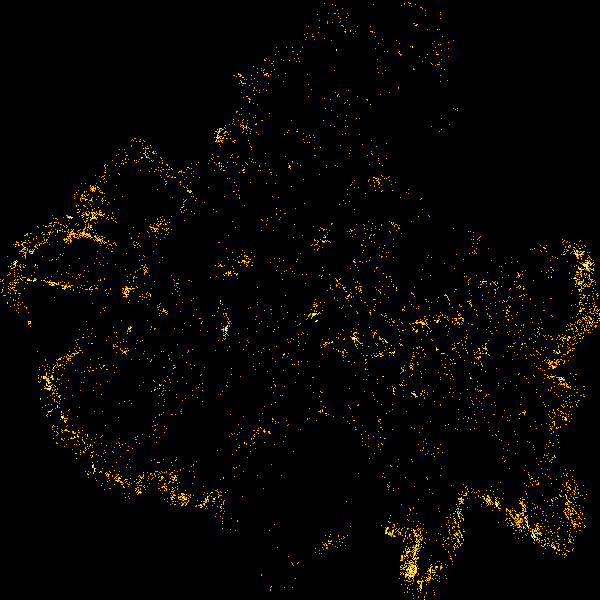

In [138]:
agg = ds.Canvas().points(all_cells, "x", "y")
ds.tf.set_background(ds.tf.shade(agg, cmap=cc.fire), "black")

In [91]:
def dbscanner(gdf, distance_threshold=100, min_cells=20):
    coordinates = np.array([[point.x, point.y] for point in gdf["geometry"]])
    dbscan = DBSCAN(eps=distance_threshold / microns_per_pixel, min_samples=min_cells)
    gdf.loc[:, "cluster"] = dbscan.fit_predict(coordinates)
    return gdf

In [130]:
res = dbscanner(all_cells, distance_threshold=300)

In [131]:
def plot_raw_clusters(gdf):
    for cluster_id in sorted(gdf["cluster"].unique()):
        cluster_points = gdf[gdf["cluster"] == cluster_id]
        if cluster_id != -1:
            # Plot clusters
            plt.scatter(cluster_points["geometry"].x, cluster_points["geometry"].y, label=f"Cluster {cluster_id}", s=0.1, linewidths=0)
        # else:
        #     # Plot noise points
        #     plt.scatter(cluster_points['px'], cluster_points['py'], label='Noise', color='gray', s=0.1, linewidths=0)
            
    # plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("DBSCAN Clustering")
    plt.gca().set_aspect("equal")

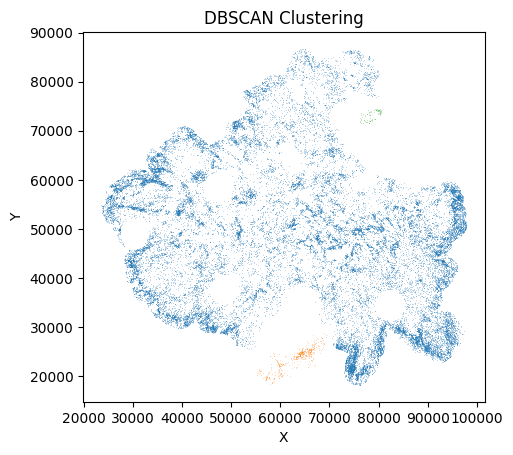

In [132]:
plot_raw_clusters(res)

In [133]:
def cluster_annos(gdf):
    
    gdf_filtered = gdf[gdf["cluster"] != -1]
    clusters = gdf_filtered.groupby("cluster")

    polygons = []
    for cluster, group in clusters:
        points = np.array([[point.x, point.y] for point in group["geometry"]])

        alpha_shape = alphashape.alphashape(points, alpha=0.01)

        # if isinstance(alpha_shape, Polygon) or isinstance(alpha_shape, MultiPolygon):
        # print(type(alpha_shape))
        polygons.append({"cluster": cluster, "geometry": alpha_shape})

    polygons_gdf = gpd.GeoDataFrame(polygons, geometry="geometry")
    polygons_gdf["area"] = polygons_gdf.geometry.area
    
    return polygons_gdf

In [134]:
res_annos = cluster_annos(res)

In [135]:
res_annos

,cluster,geometry,area
0,0,"MULTIPOLYGON (((30037 37683, 30053.5 37615, 30...",1.229225e+08
1,1,"MULTIPOLYGON (((58359 18665.5, 58192.5 18649.5...",8.599689e+05
2,2,"MULTIPOLYGON (((78245.5 71947, 78219 71919.5, ...",1.067140e+05


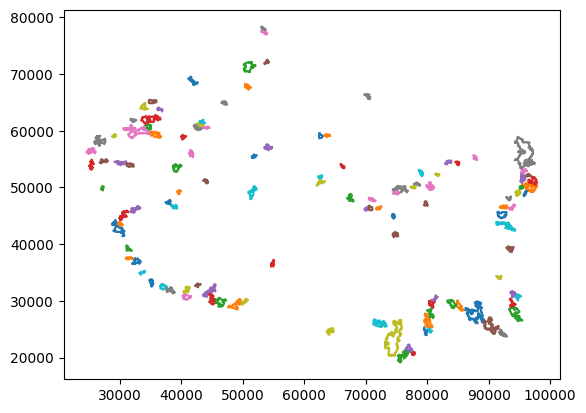

In [136]:
for anno in res_annos["geometry"].unique():
    if isinstance(anno, Polygon):
        x, y = anno.exterior.xy
        plt.plot(x, y)
    elif isinstance(anno, MultiPolygon):
        for geom in anno.geoms:
            if geom.area >= 150000:
                x, y = geom.exterior.xy
                plt.plot(x, y)

In [78]:
def set_min_area(polygons_gdf, min_area):

        filtered_polygons = polygons_gdf[polygons_gdf["area"] >= min_area].reset_index(drop=True)

        return filtered_polygons

def plot_areas(polygons_gdf, min_area):
    plt.plot(polygons_gdf["area"])
    plt.axhline(y=min_area, color="red")
    plt.ylabel("Area (pixels\u00b2)")
    plt.xlabel("Index")

def filter_clusters(filtered_polygons, gdf_filtered):
    # Only plot cells for filtered annotations
    filtered_polygons = filtered_polygons.rename(columns={"geometry": "annos"})
    gdf_filtered_annos = gdf_filtered.merge(filtered_polygons[["cluster", "annos"]], on="cluster", how="left")

    gdf_filtered_annos = gdf_filtered_annos[~gdf_filtered_annos["annos"].isna()].reset_index(drop=True)

    gdf_filtered_annos = gdf_filtered_annos.rename(columns={"geometry": "cell_pos", "annos": "geometry"})
    gdf_filtered_annos = gpd.GeoDataFrame(gdf_filtered_annos, geometry="geometry")

    return gdf_filtered_annos

def plot_filtered_clusters(gdf_filtered_annos, min_area):
    for anno in gdf_filtered_annos["geometry"].unique():
        if isinstance(anno, Polygon):
            x, y = anno.exterior.xy
            plt.plot(x, y)
        elif isinstance(anno, MultiPolygon):
            for geom in anno.geoms:
                if geom.area >= min_area:
                    x, y = geom.exterior.xy
                    plt.plot(x, y)

    # for cluster_id in sorted(gdf_filtered_annos["cluster"].unique()):
        #cluster_points = gdf_filtered_annos[gdf_filtered_annos["cluster"] == cluster_id]
        # if cluster_id != -1:
            # Plot clusters
            # plt.scatter(cluster_points["geometry"].x, cluster_points["geometry"].y, label=f"Cluster {cluster_id}", s=0.1, linewidths=0)
        # else:
        #     # Plot noise points
        #     plt.scatter(cluster_points['px'], cluster_points['py'], label='Noise', color='gray', s=0.1, linewidths=0)
            
    # plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("DBSCAN Clustering")
    plt.gca().set_aspect("equal")

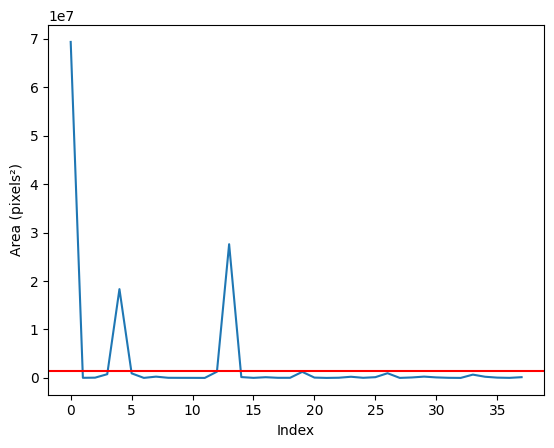

In [81]:
plot_areas(res_annos, 1500000)

In [82]:
res_filt = set_min_area(res_annos, 15000)

In [83]:
res_filt

,cluster,geometry,area
0,0,"MULTIPOLYGON (((62362 43586.5, 62397 43589.5, ...",6.938605e+07
1,1,"MULTIPOLYGON (((57058.5 19412.5, 57026 19345, ...",2.261238e+04
2,2,"MULTIPOLYGON (((60203.5 20020.5, 60237 20183.5...",5.331625e+04
3,3,"MULTIPOLYGON (((63152.5 23540.5, 63159.5 23719...",7.709758e+05
4,4,"MULTIPOLYGON (((30507.5 36192, 30575 36205.5, ...",1.833676e+07
5,5,"MULTIPOLYGON (((52695 33298, 52839.5 33379, 52...",9.419835e+05
6,7,"MULTIPOLYGON (((61691.5 38915.5, 61802.5 38875...",2.639145e+05
7,8,"MULTIPOLYGON (((39866 40587.5, 39887.5 40465.5...",2.762425e+04
8,9,"MULTIPOLYGON (((50870.5 41650, 50903.5 41754.5...",1.592088e+04
9,12,"MULTIPOLYGON (((50418 46708, 50273.5 46654.5, ...",1.287358e+06


In [84]:
res_filt_annos = filter_clusters(res_filt, res)

In [85]:
res_filt_annos

,Analysis Region,CD8,cell_pos,index_right,layer,cluster,geometry
0,Partition Zone,1.0,POINT (76192.5 18216),4,partition,0,"MULTIPOLYGON (((62362 43586.5, 62397 43589.5, ..."
1,Partition Zone,1.0,POINT (76156.5 18244),4,partition,0,"MULTIPOLYGON (((62362 43586.5, 62397 43589.5, ..."
2,Partition Zone,1.0,POINT (76102 18243),4,partition,0,"MULTIPOLYGON (((62362 43586.5, 62397 43589.5, ..."
3,Partition Zone,1.0,POINT (76186.5 18269),4,partition,0,"MULTIPOLYGON (((62362 43586.5, 62397 43589.5, ..."
4,Partition Zone,1.0,POINT (76144.5 18298.5),4,partition,0,"MULTIPOLYGON (((62362 43586.5, 62397 43589.5, ..."
...,...,...,...,...,...,...,...
40103,Partition Zone,1.0,POINT (64339 86676),4,partition,33,"MULTIPOLYGON (((64842 83551.5, 64837 83475, 64..."
40104,Partition Zone,1.0,POINT (65056 86514),4,partition,33,"MULTIPOLYGON (((64842 83551.5, 64837 83475, 64..."
40105,Partition Zone,1.0,POINT (65073.5 86565),4,partition,33,"MULTIPOLYGON (((64842 83551.5, 64837 83475, 64..."
40106,Partition Zone,1.0,POINT (65024 86609.5),4,partition,33,"MULTIPOLYGON (((64842 83551.5, 64837 83475, 64..."


In [86]:
plot_filtered_clusters(res_filt_annos, 1500000)

KeyboardInterrupt: 